In [ ]:
# Google Colab and Google Sheets
from google.colab import drive
from google.colab import auth
from google.auth import default
import gspread

# Data handling
import pandas as pd
import numpy as np
import pickle
import os
import re

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# TIFF file handling
import tifffile as tiff

# Statistics
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu

# Optional: Install statannotations if needed
!pip install statannotations


In [ ]:
def load_data(sheet_url, tab_name, tini_cd_values, tend_cd_values, tend_values):
    # Authenticate and create the client
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)

    # Open the worksheet by URL and get the specific tab by name
    sh = gc.open_by_url(sheet_url)
    worksheet = sh.worksheet(tab_name)  # Ensure tab name is correct

    # Get all the data from the sheet
    data = worksheet.get_all_values()

    # Convert to DataFrame
    headers = data[0]  # Assumes the first row is headers
    df = pd.DataFrame(data[1:], columns=headers)

    # Assuming there is a 'Replicate' column with values 'EXP1', 'EXP2', 'EXP3'
    # Create a mapping of replicate type to tini_cd, tend_cd, and tend values
    replicate_map = {
        'exp1': (tini_cd_values[0], tend_cd_values[0], tend_values[0]),
        'exp2': (tini_cd_values[1], tend_cd_values[1], tend_values[1]),
        'exp3': (tini_cd_values[2], tend_cd_values[2], tend_values[2])
    }

    # Add new columns 'tini_cd', 'tend_cd', and 'tend' based on the replicate type
    df['tini_cd'] = df['Replicate'].apply(lambda x: replicate_map[x.lower()][0] if x.lower() in replicate_map else None)
    df['tend_cd'] = df['Replicate'].apply(lambda x: replicate_map[x.lower()][1] if x.lower() in replicate_map else None)
    df['tend'] = df['Replicate'].apply(lambda x: replicate_map[x.lower()][2] if x.lower() in replicate_map else None)

    # Return the dataframe
    return df

# Example usage

expeID='vip_Cd'
tab_name = "vip_Cd_traps"  # Replace with the actual tab name

# tini_cd and tend_cd values, as well as the final tend values for exp_1, exp_2, exp_3
tini_cd_values = [0, 46, 20]     # Corresponding to exp_1, exp_2, exp_3
tend_cd_values = [40, 75, 60]    # Corresponding to exp_1, exp_2, exp_3
tend_values = [100, 114, 96]     # Corresponding to exp_1, exp_2, exp_3

# Load the data with the new columns
df = load_data(sheet_url, tab_name, tini_cd_values, tend_cd_values, tend_values)


    Index Experiment Replicate Position   Trap CellType  tini_cd  tend_cd  \
0       1     VIP_Cd      EXP1     xy01  trap1      CFP        0       40   
1       2     VIP_Cd      EXP1     xy01  trap2      VIP        0       40   
2       3     VIP_Cd      EXP1     xy02  trap1      CFP        0       40   
3       4     VIP_Cd      EXP1     xy02  trap2      VIP        0       40   
4       5     VIP_Cd      EXP1     xy02  trap3      CFP        0       40   
..    ...        ...       ...      ...    ...      ...      ...      ...   
440   441     VIP_Cd      EXP3     xy19  trap1      VIP       20       60   
441   442     VIP_Cd      EXP3     xy19  trap2      VIP       20       60   
442   443     VIP_Cd      EXP3     xy28  trap1      VIP       20       60   
443   444     VIP_Cd      EXP3     xy28  trap2      VIP       20       60   
444   445     VIP_Cd      EXP3     xy28  trap3      CFP       20       60   

     tend  
0     100  
1     100  
2     100  
3     100  
4     100  
.. 

In [ ]:


drive.mount('/content/drive')


# Find all PKL files in the directory
pkl_files = [os.path.join(base_path, f) for f in os.listdir(base_path) if f.endswith('.pkl')]

# Find all TIF files in the directory
tif_files = [os.path.join(img_path, f) for f in os.listdir(img_path) if f.endswith('.tif')]

# Print the found PKL files
#print("Found PKL files:", pkl_files)


frames2min=5
pixel2um=11

Mounted at /content/drive
Found PKL files: ['/content/drive/MyDrive/SYNC_Projects/VIP205/MotherMachine/Cd_MontagesPKL/vip_Cd_EXP3_xy01_trap7_DIC.pkl', '/content/drive/MyDrive/SYNC_Projects/VIP205/MotherMachine/Cd_MontagesPKL/vip_Cd_EXP2_xy14_trap6_DIC.pkl', '/content/drive/MyDrive/SYNC_Projects/VIP205/MotherMachine/Cd_MontagesPKL/vip_Cd_EXP2_xy02_trap11_DIC.pkl', '/content/drive/MyDrive/SYNC_Projects/VIP205/MotherMachine/Cd_MontagesPKL/vip_Cd_EXP3_xy11_trap6_DIC.pkl', '/content/drive/MyDrive/SYNC_Projects/VIP205/MotherMachine/Cd_MontagesPKL/vip_Cd_EXP2_xy26_trap1_DIC.pkl', '/content/drive/MyDrive/SYNC_Projects/VIP205/MotherMachine/Cd_MontagesPKL/vip_Cd_EXP3_xy09_trap1_DIC.pkl', '/content/drive/MyDrive/SYNC_Projects/VIP205/MotherMachine/Cd_MontagesPKL/vip_Cd_EXP2_xy07_trap6_DIC.pkl', '/content/drive/MyDrive/SYNC_Projects/VIP205/MotherMachine/Cd_MontagesPKL/vip_Cd_EXP2_xy04_trap7_DIC.pkl', '/content/drive/MyDrive/SYNC_Projects/VIP205/MotherMachine/Cd_MontagesPKL/vip_Cd_EXP2_xy03_trap10_D

In [ ]:

def extract_file_identifier(file_path):
    base_name = os.path.basename(file_path)
    name_without_extension = os.path.splitext(base_name)[0]
    parts = name_without_extension.split('_')
    identifier = '_'.join(parts[2:5])
    return identifier

def get_identifiers_by_cell_type(all_data, df, cell_type_filter):
    identifiers = []

    for file in all_data.keys():
        identifier = extract_file_identifier(file)
        cell_type = get_cell_type(df, identifier)
        if cell_type == cell_type_filter:
            identifiers.append(identifier)

    return identifiers

def get_cell_type(df, position):
    # Since position is directly passed, filter the DataFrame by position
    filtered_df = df[df['Position'] == position]

    # Return the CellType if found, otherwise return None
    if not filtered_df.empty:
        return filtered_df['CellType'].values[0]
    else:
        print(f"Warning: No cell type found for position {position}")
        return None



def get_time_series_data(all_data, identifier):
    for file, data in all_data.items():
        if extract_file_identifier(file) == identifier:
            for trap_data in data:
                if trap_data['id'] in {1, 2}:
                    frames = list(range(len(trap_data['y_breakpoints'])))
                    cell_lengths = trap_data['y_breakpoints']
                    return frames, cell_lengths
    return [], []


In [ ]:

# Function to match .pkl files with .tif files
def match_pkl_tif(pkl_files, tif_files):
    matched_files = []
    for pkl_file in pkl_files:
        pkl_identifier = extract_file_identifier(pkl_file)
        for tif_file in tif_files:
            tif_identifier = extract_file_identifier(tif_file)
            if pkl_identifier == tif_identifier:
                matched_files.append((pkl_file, tif_file))
                break
    return matched_files

# Function to load a PKL file
def load_pkl(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data


matched_files = match_pkl_tif(pkl_files, tif_files)

# Load each PKL file
all_data = {}
for pkl_file, _ in matched_files:
    data = load_pkl(pkl_file)
    all_data[pkl_file] = data



In [ ]:
def plot_tracking(time_series_data, division_events, image_path, tini_cd, tend_cd, tend):
    frames, cell_lengths = time_series_data
    identifier = extract_file_identifier(image_path)

    if len(frames) > 0:
        _, _, cell_divisions = division_events

        # Compute the derivative of cell lengths
        cell_lengths = np.array(cell_lengths)
        derivatives = np.diff(cell_lengths) / np.diff(frames)
        derivative_frames = frames[1:]

        # Load the image
        image = plt.imread(image_path)

        # Create subplots
        fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(6, 10))

        # Plot the image
        ax0.imshow(image, cmap='gray')
        ax0.axis('off')
        ax0.set_title(identifier)

        # Define a buffer (5% of the data range) to avoid tight x-axis limits
        frame_min = min(frames)
        frame_max = max(frames)
        x_buffer = (frame_max - frame_min) * 0.05  # 5% buffer

        # Plot the time series with division events
        ax1.plot(frames, cell_lengths, color='black', label='Cell Length')
        ax1.scatter([frames[i] for i in range(len(cell_divisions)) if cell_divisions[i]],
                    [cell_lengths[i] for i in range(len(cell_divisions)) if cell_divisions[i]],
                    color='#EC008C', label='Division Event')
        ax1.set_ylabel('Cell Length (pixels)')
        ax1.legend()

        # Annotate tini_cd, tend_cd, and tend with vertical lines
        ax1.axvline(tini_cd-0.1, color='green', linestyle='--', label='tini_cd')
        ax1.axvline(tend_cd, color='blue', linestyle='--', label='tend_cd')
        ax1.axvline(tend+0.1, color='purple', linestyle='--', label='tend')

        # Adjust x-axis limits with padding
        ax1.set_xlim([frame_min - x_buffer, frame_max + x_buffer])

        # Plot the derivative of cell lengths
        ax2.plot(derivative_frames, derivatives, color='blue', label='Derivative of Cell Length')
        ax2.scatter([frames[i] for i in range(len(cell_divisions)) if cell_divisions[i]],
                    [derivatives[i] for i in range(len(cell_divisions)) if cell_divisions[i]],
                    color='#EC008C', label='Division Event')

        # Annotate tini_cd, tend_cd, and tend with vertical lines in the derivative plot
        ax2.axvline(tini_cd-0.1, color='green', linestyle='--', label='tini_cd')
        ax2.axvline(tend_cd, color='blue', linestyle='--', label='tend_cd')
        ax2.axvline(tend+0.1, color='purple', linestyle='--', label='tend')

        # Adjust x-axis limits with padding
        ax2.set_xlim([frame_min - x_buffer, frame_max + x_buffer])

        ax2.set_xlabel('Time (frames)')
        ax2.set_ylabel('Derivative of Cell Length (pixels/frame)')
        plt.tight_layout()

        plt.show()
    else:
        print("Not plotted: %s " % image_path)

In [ ]:
def get_time_series_of_cell_lengths(all_data, df, identifier):
    x2frame = 11  # Define the constant for conversion
    trap_lengths = {}

    for file, data in all_data.items():
        if extract_file_identifier(file) == identifier:
            for trap_data in data:
                trap_id = trap_data['id']

                # Only consider traps with id=1 and id=2
                if trap_id not in {1, 2}:
                    continue

                x_breakpoints = trap_data['x_breakpoints']
                y_breakpoints = trap_data['y_breakpoints']

                frames = [x / x2frame for x in x_breakpoints]

                # Ensure both x_breakpoints and y_breakpoints have the same length
                min_length = min(len(x_breakpoints), len(y_breakpoints))
                x_breakpoints = x_breakpoints[:min_length]
                y_breakpoints = y_breakpoints[:min_length]

                # Only process if there is data to process
                if x_breakpoints and y_breakpoints:
                    if trap_id not in trap_lengths:
                        trap_lengths[trap_id] = []
                    trap_lengths[trap_id].append(y_breakpoints)

            if 1 in trap_lengths and 2 in trap_lengths:
                lengths_1 = trap_lengths[1][0]
                lengths_2 = trap_lengths[2][0]
                cell_lengths = [abs(l1 - l2) for l1, l2 in zip(lengths_1, lengths_2)]

                # Sort the frames and cell_lengths
                sorted_indices = np.argsort(frames[:len(cell_lengths)])
                sorted_frames = np.array(frames[:len(cell_lengths)])[sorted_indices]
                sorted_cell_lengths = np.array(cell_lengths)[sorted_indices]

                return sorted_frames.tolist(), sorted_cell_lengths.tolist()

    return [], []

def analyze_division_events(time_series_data, threshold=-5):
    frames, cell_lengths = time_series_data

    # Sort frames and cell_lengths by frames
    sorted_indices = np.argsort(frames)
    frames = np.array(frames)[sorted_indices]
    cell_lengths = np.array(cell_lengths)[sorted_indices]

    cell_divisions = [False] * len(cell_lengths)

    # Compute the derivative of cell lengths
    derivatives = np.diff(cell_lengths) / np.diff(frames)
    derivative_frames = frames[1:]  # Frames corresponding to derivatives

    # Identify local minimums in the derivative that are below the threshold
    for i in range(1, len(derivatives) - 1):
        if derivatives[i] < threshold and derivatives[i] < derivatives[i - 1] and derivatives[i] < derivatives[i + 1]:
            cell_divisions[i + 1] = True  # Mark the division in cell_divisions

    # Print the frames where cell divisions occur (x values)
    division_frames = [frames[i] for i in range(len(frames)) if cell_divisions[i]]
    print("\ndivision_events=", division_frames)

    # Print the corresponding derivatives (y values) where cell divisions occur
    division_derivatives = [derivatives[i] for i in range(len(derivatives)) if cell_divisions[i + 1]]
    #print("** (y-values, derivatives):", division_derivatives)

    return frames, cell_lengths, cell_divisions




In [ ]:


def extract_position_and_trap(identifier):
    """Extracts both the position (e.g., 'xy09') and trap (e.g., 'trap12') from the file identifier."""
    position_match = re.search(r'(xy\d+)', identifier)
    trap_match = re.search(r'(trap\d+)', identifier)

    position = position_match.group(1) if position_match else None
    trap = trap_match.group(1) if trap_match else None

    return position, trap

def get_cell_type(df, position, trap):
    """Fetches the CellType for the given position and trap."""
    filtered_df = df[(df['Position'] == position) & (df['Trap'] == trap)]

    if not filtered_df.empty:
        cell_type = filtered_df['CellType'].values[0]  # Take the first match
        return cell_type
    else:
        print(f"Warning: No cell type found for position {position} and trap {trap}")
        return None

def get_identifiers_by_cell_type(all_data, df, cell_type_filter):
    """Get identifiers that match the specified cell type."""
    identifiers = []
    for file in all_data.keys():
        identifier = extract_file_identifier(file)

        # Extract both position and trap
        position, trap = extract_position_and_trap(identifier)

        # Now pass both position and trap to get_cell_type
        cell_type = get_cell_type(df, position, trap)
        if cell_type == cell_type_filter:
            identifiers.append(identifier)

    return identifiers

def analyze_division_events(time_series_data, tend_cd, threshold=-5):
    frames, cell_lengths = time_series_data

    # Sort frames and cell_lengths by frames
    sorted_indices = np.argsort(frames)
    frames = np.array(frames)[sorted_indices]
    cell_lengths = np.array(cell_lengths)[sorted_indices]

    cell_divisions = [False] * len(cell_lengths)

    # Compute the derivative of cell lengths
    derivatives = np.diff(cell_lengths) / np.diff(frames)
    derivative_frames = frames[1:]

    # Identify local minimums in the derivative that are below the threshold
    for i in range(1, len(derivatives) - 1):
        if derivatives[i] < threshold and derivatives[i] < derivatives[i - 1] and derivatives[i] < derivatives[i + 1]:
            cell_divisions[i + 1] = True  # Mark the division in cell_divisions

    # Check if any division happens after tend_cd
    survived = any(frame >= tend_cd and cell_divisions[i] for i, frame in enumerate(frames))

    return frames, cell_lengths, cell_divisions, survived

def update_df_with_survival_status_and_plot(all_data, df, cell_type_filter=None):
    """Updates df with survival status based on whether a cell divided after tend_cd and generates plots."""
    # Ensure the DataFrame has the column `is_alive`
    if 'is_alive' not in df.columns:
        df['is_alive'] = None  # Initialize the column

    identifiers = get_identifiers_by_cell_type(all_data, df, cell_type_filter)

    # First pass: find global min and max frames
    global_min_frame = float('inf')
    global_max_frame = float('-inf')

    # First loop: determine global x-limits
    for identifier in identifiers:
        # Extract the correct position and trap from the identifier
        position, trap = extract_position_and_trap(identifier)

        if position is None or trap is None:
            print(f"Warning: Could not extract position or trap from identifier {identifier}, skipping...")
            continue

        # Analyze division events for this identifier
        time_series_data = get_time_series_of_cell_lengths(all_data, df, identifier)
        if time_series_data[0]:  # Only analyze if there is data
            # Retrieve tend_cd for this specific identifier
            filtered_df = df[(df['Position'] == position) & (df['Trap'] == trap)]
            if not filtered_df.empty:
                tend_cd = filtered_df['tend_cd'].values[0]
            else:
                print(f"Warning: No tend_cd found for identifier {identifier}, skipping...")
                continue

            frames, cell_lengths, cell_divisions, survived = analyze_division_events(time_series_data, tend_cd)

            # Update global min and max frames
            global_min_frame = min(global_min_frame, min(frames))
            global_max_frame = max(global_max_frame, max(frames))

    # Second pass: plot with the determined global x-limits
    total_cells_with_divisions = 0
    cells_with_divisions_after_tend_cd = 0

    for identifier in identifiers:
        # Extract the correct position and trap from the identifier
        position, trap = extract_position_and_trap(identifier)

        if position is None or trap is None:
            print(f"Warning: Could not extract position or trap from identifier {identifier}, skipping...")
            continue

        # Filter based on cell type if specified
        if cell_type_filter is not None:
            cell_type = get_cell_type(df, position, trap)
            if cell_type_filter != cell_type:
                continue

        # Filter the DataFrame for the correct position and trap
        filtered_df = df[(df['Position'] == position) & (df['Trap'] == trap)]
        if filtered_df.empty:
            print(f"Warning: No data found for position {position} and trap {trap}, skipping...")
            continue

        # Retrieve tend_cd for this specific identifier
        tend_cd = filtered_df['tend_cd'].values[0]

        # Analyze division events for this identifier
        time_series_data = get_time_series_of_cell_lengths(all_data, df, identifier)
        if time_series_data[0]:  # Only analyze if there is data
            frames, cell_lengths, cell_divisions, survived = analyze_division_events(time_series_data, tend_cd)

            if any(cell_divisions):  # Check if there are any division events
                total_cells_with_divisions += 1
                if survived:
                    cells_with_divisions_after_tend_cd += 1

                # Update the 'is_alive' status in the DataFrame for this position and trap
                df.loc[(df['Position'] == position) & (df['Trap'] == trap), 'is_alive'] = survived

            # Generate the plot with survival status and global x-limits
            plot_cell_lengths(time_series_data, (frames, cell_lengths, cell_divisions, survived), identifier,
                              tini_cd=filtered_df['tini_cd'].values[0],
                              tend_cd=filtered_df['tend_cd'].values[0],
                              tend=filtered_df['tend'].values[0],
                              global_min_frame=global_min_frame, global_max_frame=global_max_frame)

    if total_cells_with_divisions == 0:
        survival_rate = 0.0  # Avoid division by zero
    else:
        survival_rate = cells_with_divisions_after_tend_cd / total_cells_with_divisions

    return survival_rate, df  # Return the updated DataFrame as well


def plot_cell_lengths(time_series_data, division_events, image_path, tini_cd, tend_cd, tend, global_min_frame, global_max_frame):
    frames, cell_lengths = time_series_data
    frames = np.array(frames) - tini_cd  # Shift frames by tini_cd

    # Extract experiment and trap from the file identifier (assuming it's in the format 'EXPX_xyYY_trapZZ')
    identifier = extract_file_identifier(image_path)
    exp, trap = extract_position_and_trap(identifier)

    if len(frames) > 0:
        _, _, cell_divisions, survived = division_events

        # Set the survival status and line color based on survival
        survival_status = "Survived" if survived else "Not Survived"
        line_color = 'blue' if survived else 'red'

        # Create subplots
        fig, ax0 = plt.subplots(1, 1, figsize=(8, 4))

        # Plot the time series with division events
        ax0.plot(frames, cell_lengths, color=line_color, label=f'Cell Length ({survival_status})')
        ax0.scatter([frames[i] for i in range(len(cell_divisions)) if cell_divisions[i]],
                    [cell_lengths[i] for i in range(len(cell_divisions)) if cell_divisions[i]],
                    color='red', label='Division Event')
        ax0.set_ylabel('Cell Length (pixels)')
        #ax0.legend()

        # Annotate tini_cd, tend_cd, and tend with vertical lines
        ax0.axvline(0, color='green', linestyle='--', label='tini_cd')  # Now at 0
        ax0.axvline(tend_cd - tini_cd, color='blue', linestyle='--', label='tend_cd')  # Shifted
        ax0.axvline(tend - tini_cd, color='purple', linestyle='--', label='tend')  # Shifted

        # Annotate the interval between tini_cd and tend_cd with a red box (starts at 0)
        ax0.axvspan(0, tend_cd - tini_cd, color='red', alpha=0.3, label='Cadmium Exposure')

        # Use global x-limits
        ax0.set_xlim([global_min_frame, global_max_frame])

        # Set title including experiment, trap, and survival status
        ax0.set_title(f"{image_path}: {survival_status}")

        plt.tight_layout()
        plt.show()
    else:
        print(f"Not plotted: {image_path}")

In [ ]:
def get_breakpoints(all_data, identifier):
    """
    Extracts x_breakpoints and y_breakpoints for all traps from the given data.

    Parameters:
    - all_data (dict): Dictionary containing the data for each file.
    - identifier (str): Identifier to filter the relevant file.

    Returns:
    - dict: A dictionary containing x_breakpoints and y_breakpoints for all traps.
    """
    breakpoints = {}

    for file, data in all_data.items():
        if extract_file_identifier(file) == identifier:
            for trap_data in data:
                trap_id = trap_data['id']

                x_breakpoints = trap_data.get('x_breakpoints', [])
                y_breakpoints = trap_data.get('y_breakpoints', [])

                # Ensure both x_breakpoints and y_breakpoints have the same length
                min_length = min(len(x_breakpoints), len(y_breakpoints))
                x_breakpoints = x_breakpoints[:min_length]
                y_breakpoints = y_breakpoints[:min_length]

                if trap_id not in breakpoints:
                    breakpoints[trap_id] = {'x_breakpoints': [], 'y_breakpoints': []}

                breakpoints[trap_id]['x_breakpoints'].extend(x_breakpoints)
                breakpoints[trap_id]['y_breakpoints'].extend(y_breakpoints)

    return breakpoints


In [ ]:


def create_image_with_breakpoints_plot(tif_file, breakpoints, tini_cd, t_end_cd, channel_width=11):
    try:
        # Load the image from the .tif file
        tif_image = tiff.imread(tif_file)

        # Flip the image vertically
        tif_image = np.flipud(tif_image)

        # Calculate the maximum x_breakpoint
        max_x = max(
            max(trap_data.get('x_breakpoints', [])) for trap_data in breakpoints.values()
        )

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(tif_image, cmap='gray')

        # Overlay horizontal lines for each breakpoint
        for trap_id, trap_data in breakpoints.items():
            x_breakpoints = trap_data.get('x_breakpoints', [])
            y_breakpoints = trap_data.get('y_breakpoints', [])

            for x, y in zip(x_breakpoints, y_breakpoints):
                ax.hlines(y, x, x + channel_width, colors='yellow', linestyles='-', linewidth=2)

        # Add the red rectangle to annotate the interval
        rect = patches.Rectangle(
            (tini_cd, 0),  # Bottom-left corner of the rectangle
            t_end_cd - tini_cd,  # Width of the rectangle
            tif_image.shape[0],  # Height of the rectangle (full image height)
            linewidth=2,
            edgecolor='#EC008C',
            facecolor='#EC008C'
        )
        ax.add_patch(rect)

        # Adjust x-axis limits
        ax.set_xlim(0, max_x)
        ax.axis('off')  # Hide axes for better visualization
        ax.set_title(f"{tif_file.split('/')[-1]}")

        plt.close(fig)

        return fig, ax

    except Exception as e:
        print(f"Error displaying the image or plotting breakpoints: {e}")
        return None, None


In [ ]:
def create_cell_lengths_plot(time_series_data, division_events, image_path, tini_cd, tend_cd, tend, global_min_frame, global_max_frame):
    """
    Creates a plot of cell lengths with division events.

    Parameters:
    - time_series_data (tuple): Time-series data (frames, cell_lengths).
    - division_events (tuple): Division events and survival status.
    - image_path (str): Path to the image file (for title extraction).
    - tini_cd, tend_cd, tend (float): Time markers for cadmium exposure and recovery.
    - global_min_frame, global_max_frame (float): Global frame boundaries.

    Returns:
    - fig, ax: Matplotlib figure and axes objects for the cell lengths plot.
    """
    frames, cell_lengths = time_series_data
    frames = np.array(frames) - tini_cd  # Shift frames by tini_cd

    if len(frames) > 0:
        _, _, cell_divisions, survived = division_events

        # Set the survival status and line color based on survival
        survival_status = "Survived" if survived else "Not Survived"
        line_color = 'blue' if survived else 'grey'

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(6, 2))

        # Plot the time series with division events
        ax.plot(frames, cell_lengths, color=line_color, label=f'Cell Length ({survival_status})')
        ax.scatter([frames[i] for i in range(len(cell_divisions)) if cell_divisions[i]],
                   [cell_lengths[i] for i in range(len(cell_divisions)) if cell_divisions[i]],
                   color='#EC008C', label='Division Event')
        ax.set_ylabel('Cell Length (pixels)')
        ax.legend()

        # Annotate tini_cd, tend_cd, and tend with vertical lines
        ax.axvline(0, color='grey', linestyle='--', label='tini_cd')  # Now at 0
        ax.axvline(tend_cd - tini_cd, color='grey', linestyle='--', label='tend_cd')  # Shifted
        ax.axvline(tend - tini_cd, color='grey', linestyle='--', label='tend')  # Shifted

        # Annotate the interval between tini_cd and tend_cd with a red box (starts at 0)
        ax.axvspan(0, tend_cd - tini_cd, color='#EC008C', alpha=0.3, label='Cadmium Exposure')

        # Use global x-limits
        ax.set_xlim([global_min_frame, global_max_frame])

        # Set title including experiment, trap, and survival status
        ax.set_title(f"Time Series: {survival_status}")


        plt.close(fig)
        return fig, ax
    else:
        print(f"No data to plot for: {image_path}")
        return None, None


In [ ]:
def plot_image_and_cell_lengths(
    tif_file,
    this_breakpoints,
    time_series_data,
    division_events,
    tini_cd,
    tend_cd,
    tend,
    global_min_frame,
    global_max_frame,
    channel_width=11,
    base_path=None,
    image_path=None,
    frames2min=5,
    pixel2um=1 / 11,  # Corrected for pixels-to-micrometers conversion
):
    """
    Combines and displays the image with breakpoints and the cell lengths plot,
    scaling axes for time (minutes) and cell length (micrometers).
    """
    # Create the individual plots (do not show them)
    fig_img, ax_img = create_image_with_breakpoints_plot(
        tif_file, this_breakpoints, tini_cd, tend_cd, channel_width=channel_width
    )
    fig_plot, ax_plot = create_cell_lengths_plot(
        time_series_data, division_events, tif_file, tini_cd, tend_cd, tend, global_min_frame, global_max_frame
    )

    # Combine the two plots vertically
    if fig_img and fig_plot:
        combined_fig = plt.figure(figsize=(8, 4))
        gs = combined_fig.add_gridspec(2, 1, height_ratios=[4, 2])

        # Add the image with breakpoints
        combined_ax_img = combined_fig.add_subplot(gs[0])
        combined_ax_img.imshow(ax_img.images[0].get_array(), cmap="gray")
        combined_ax_img.set_xlim(ax_img.get_xlim())
        combined_ax_img.set_ylim(ax_img.get_ylim())
        combined_ax_img.axis("off")
        combined_ax_img.set_title(ax_img.get_title())

        # Overlay breakpoints on the combined image
        for trap_id, trap_data in this_breakpoints.items():
            x_breakpoints = [x for x in trap_data.get("x_breakpoints", [])]
            y_breakpoints = trap_data.get("y_breakpoints", [])
            for x, y in zip(x_breakpoints, y_breakpoints):
                combined_ax_img.hlines(
                    y, x, x + channel_width, colors="blue", linestyles="-", linewidth=1
                )

        # Add the red rectangle to annotate the interval
        rect = patches.Rectangle(
            (tini_cd * channel_width, 0),  # Bottom-left corner of the rectangle
            (tend_cd - tini_cd) * channel_width,  # Width of the rectangle
            ax_img.get_ylim()[1],  # Height of the rectangle (image height)
            linewidth=2,
            edgecolor="#EC008C",
            facecolor="none",
        )
        combined_ax_img.add_patch(rect)

        # Add the cell lengths plot
        combined_ax_plot = combined_fig.add_subplot(gs[1])
        # Scale x-axis and y-axis data
        scaled_x = ax_plot.lines[0].get_xdata() * frames2min
        scaled_y = ax_plot.lines[0].get_ydata() * pixel2um

        # Plot scaled data
        combined_ax_plot.plot(
            scaled_x, scaled_y, color="blue", label="Cell length"
        )
        combined_ax_plot.scatter(
            ax_plot.collections[0].get_offsets()[:, 0] * frames2min,
            ax_plot.collections[0].get_offsets()[:, 1] * pixel2um,
            color="#EC008C", label="Division Event",
        )
        #max_frame=global_max_frame * frames2min
        max_frame=480

        combined_ax_plot.set_xlim(
            global_min_frame * frames2min, max_frame
        )
        combined_ax_plot.set_ylim(0, max(scaled_y) * 1.1)
        combined_ax_plot.set_xlabel("Time (minutes)")
        combined_ax_plot.set_ylabel(r"Length ($\mu$m)")

        # Set xticks at intervals of 60 minutes
        xticks = np.arange(global_min_frame * frames2min, global_max_frame * frames2min , 60)
        combined_ax_plot.set_xticks(xticks)

        # Add vertical lines and shaded region (scale x-axis)
        combined_ax_plot.axvline(0, color="#EC008C", linestyle="-")
        combined_ax_plot.axvline(
            (tend_cd - tini_cd) * frames2min, color="#EC008C", linestyle="-"
        )
        combined_ax_plot.axvline(
            (tend - tini_cd) * frames2min, color="grey", linestyle="-"
        )
        combined_ax_plot.axvspan(
            0,
            (tend_cd - tini_cd) * frames2min,
            color="#EC008C",
            alpha=0.3
        )
        combined_ax_plot.legend(fontsize=8, loc="upper right")

        plt.tight_layout()

        # Define the file name and save as PDF in the base path
        fig_name = os.path.basename(image_path).replace(".tif", ".pdf")
        fig_path = os.path.join(base_path, fig_name)
        plt.savefig(fig_path)  # Save as PDF
        print("Exporting %s" % fig_path)

        plt.show()
    else:
        print("Could not create one or both plots.")


Exporting /content/drive/MyDrive/SYNC_Projects/VIP205/MotherMachine/figures/vip_Cd_EXP3_xy15_trap4_DIC.pdf


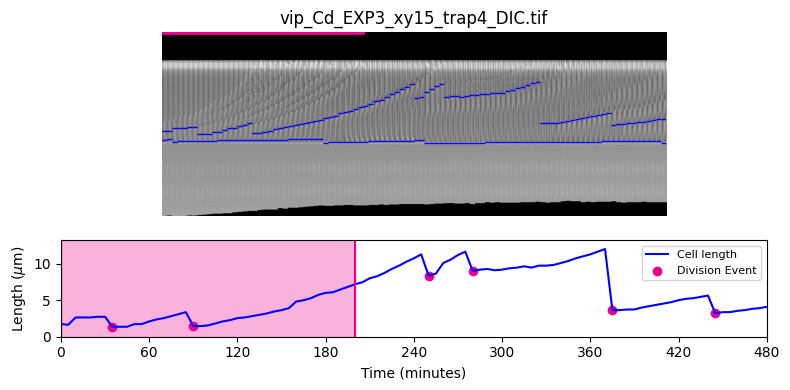

PKL files with no division events: []


In [ ]:
import os

# Define the base path where the files will be stored
base_path = '/content/drive/MyDrive/SYNC_Projects/VIP205/MotherMachine/figures/'

# Create the directory if it doesn't exist
if not os.path.exists(base_path):
    os.makedirs(base_path)


# Example usage

x2frame = 11

cmap = plt.get_cmap("viridis")  # Use the viridis colormap

files_to_plot=[( '/content/drive/MyDrive/SYNC_Projects/VIP205/MotherMachine/MontagesPKL/vip_Cd_EXP3_xy15_trap4_DIC.pkl', '/content/drive/MyDrive/SYNC_Projects/VIP205/MotherMachine/Cd_MontagesTIF/vip_Cd_EXP3_xy15_trap4_DIC.tif')]
#files_to_plot = matched_files #All files
num_files_to_plot = len(files_to_plot)

# List to store PKL files with no division events
no_division_files = []

# Initialize global min and max frames
if num_files_to_plot>1:
    global_min_frame = float('inf')
    global_max_frame = float('-inf')

    # First pass: Find global min and max frames across all files
    for pkl_file, tif_file in files_to_plot:
        identifier = extract_file_identifier(pkl_file)
        time_series_data = get_time_series_of_cell_lengths(all_data, df, identifier)


        if time_series_data[0]:  # Only consider if there is data
            frames = time_series_data[0]  # Extract frames from time_series_data
            global_min_frame = -40  # min(global_min_frame, min(frames))
            global_max_frame = max(global_max_frame, max(frames))
else:
  global_min_frame=0
  global_max_frame=100

# Second pass: Generate plots with global x-limits
for pkl_file, tif_file in files_to_plot:
    identifier = extract_file_identifier(pkl_file)
    time_series_data = get_time_series_of_cell_lengths(all_data, df, identifier)


    # Extract tini_cd, tend_cd, and tend from the DataFrame for this identifier
    filtered_df = df[df['Position'] == identifier.split('_')[1]]  # Assuming identifier contains Position like 'EXP1_xy01'
    if not filtered_df.empty:
        tini_cd = float(filtered_df['tini_cd'].values[0])
        tend_cd = float(filtered_df['tend_cd'].values[0])
        tend = float(filtered_df['tend'].values[0])
    else:
        tini_cd, tend_cd, tend = None, None, None

    # Call analyze_division_events and pass tend_cd
    division_events = analyze_division_events(time_series_data, tend_cd)

    # Check if there are no division events
    if not any(division_events[2]):
        no_division_files.append(pkl_file)


    this_breakpoints=get_breakpoints(all_data, identifier)

    #show_image_with_breakpoints(tif_file, this_breakpoints, x2frame)

    #plot_cell_lengths(time_series_data, division_events, tif_file, tini_cd, tend_cd, tend, global_min_frame, global_max_frame)

    plot_image_and_cell_lengths(
        tif_file,
        this_breakpoints,
        time_series_data,
        division_events,
        tini_cd,
        tend_cd,
        tend,
        global_min_frame,
        global_max_frame,
        channel_width=x2frame,
        base_path=base_path,
        image_path=tif_file
    )

# Print or store the list of PKL files with no division events
print("PKL files with no division events:", no_division_files)


In [ ]:
# Remove files with no division events from matched_files and all_data
no_division_files_removed = []  # List to store the files being removed

matched_files = [(pkl_file, tif_file) for pkl_file, tif_file in matched_files if pkl_file not in no_division_files or no_division_files_removed.append((pkl_file, tif_file))]

# Print the removed files
if no_division_files_removed:
    print("Removed the following files due to no division events:")
    for removed_file in no_division_files_removed:
        print(removed_file)
else:
    print("No files were removed.")

# Load each PKL file
all_data = {}
for pkl_file, tif_file in matched_files:
    data = load_pkl(pkl_file)
    all_data[pkl_file] = data


No files were removed.


In [ ]:


# Modify the update_df_with_survival_status_and_plot function to keep track of survival frequency
def update_df_with_survival_status_and_plot(all_data, df, cell_type_filter=None):
    """Updates df with survival status based on whether a cell divided after tend_cd and generates plots."""
    # Ensure the DataFrame has the column `is_alive`
    if 'is_alive' not in df.columns:
        df['is_alive'] = None  # Initialize the column

    identifiers = get_identifiers_by_cell_type(all_data, df, cell_type_filter)

    # First pass: find global min and max frames
    global_min_frame = float('inf')
    global_max_frame = float('-inf')

    # First loop: determine global x-limits
    for identifier in identifiers:
        # Extract the correct position and trap from the identifier
        position, trap = extract_position_and_trap(identifier)

        if position is None or trap is None:
            print(f"Warning: Could not extract position or trap from identifier {identifier}, skipping...")
            continue

        # Analyze division events for this identifier
        time_series_data = get_time_series_of_cell_lengths(all_data, df, identifier)
        if time_series_data[0]:  # Only analyze if there is data
            # Retrieve tend_cd for this specific identifier
            filtered_df = df[(df['Position'] == position) & (df['Trap'] == trap)]
            if not filtered_df.empty:
                tend_cd = filtered_df['tend_cd'].values[0]
            else:
                print(f"Warning: No tend_cd found for identifier {identifier}, skipping...")
                continue

            frames, cell_lengths, cell_divisions, survived = analyze_division_events(time_series_data, tend)

            # Update global min and max frames
            global_min_frame = min(global_min_frame, min(frames))
            global_max_frame = max(global_max_frame, max(frames))

    # Second pass: plot with the determined global x-limits
    total_cells_with_divisions = 0
    cells_with_divisions_after_tend_cd = 0
    survival_count = 0

    for identifier in identifiers:
        # Extract the correct position and trap from the identifier
        position, trap = extract_position_and_trap(identifier)

        if position is None or trap is None:
            print(f"Warning: Could not extract position or trap from identifier {identifier}, skipping...")
            continue

        # Filter based on cell type if specified
        if cell_type_filter is not None:
            cell_type = get_cell_type(df, position, trap)
            if cell_type_filter != cell_type:
                continue

        # Filter the DataFrame for the correct position and trap
        filtered_df = df[(df['Position'] == position) & (df['Trap'] == trap)]
        if filtered_df.empty:
            print(f"Warning: No data found for position {identifier}, skipping...")
            continue

        # Retrieve tend_cd for this specific identifier
        tend_cd = filtered_df['tend_cd'].values[0]
        tini_cd = filtered_df['tini_cd'].values[0]

        # Analyze division events for this identifier
        time_series_data = get_time_series_of_cell_lengths(all_data, df, identifier)
        if time_series_data[0]:  # Only analyze if there is data
            frames, cell_lengths, cell_divisions, survived = analyze_division_events(time_series_data, tend_cd)

            if any(cell_divisions):  # Check if there are any division events
                total_cells_with_divisions += 1
                if survived:
                    cells_with_divisions_after_tend_cd += 1

                # Update the 'is_alive' status in the DataFrame for this position and trap
                df.loc[(df['Position'] == position) & (df['Trap'] == trap), 'is_alive'] = survived

                # Keep track of survival count
                if survived:
                    survival_count += 1

            # Generate the plot with survival status and global x-limits
            global_min_frame=-40
            plot_cell_lengths(time_series_data, (frames, cell_lengths, cell_divisions, survived), identifier,
                              tini_cd=filtered_df['tini_cd'].values[0],
                              tend_cd=filtered_df['tend_cd'].values[0],
                              tend=filtered_df['tend'].values[0],
                              global_min_frame=global_min_frame, global_max_frame=global_max_frame)

    if total_cells_with_divisions == 0:
        freq_survival = 0.0  # Avoid division by zero
    else:
        freq_survival = survival_count / total_cells_with_divisions

    print(f"Survival frequency: {freq_survival}")
    return freq_survival, df  # Return the updated DataFrame as well



# Example usage
#cell_type_filter = "VIP"  # Optionally specify the cell type

# Calculate the survival rate, update the DataFrame, and generate plots
#survival_rate, updated_df = update_df_with_survival_status_and_plot(all_data, df, cell_type_filter)
#print(f'Survival rate of {cell_type_filter}: {survival_rate}')

# Perform the same for CFP cells
#cell_type_filter = "CFP"
#survival_rate, updated_df = update_df_with_survival_status_and_plot(all_data, df, cell_type_filter)
#print(f'Survival rate of {cell_type_filter}: {survival_rate}')


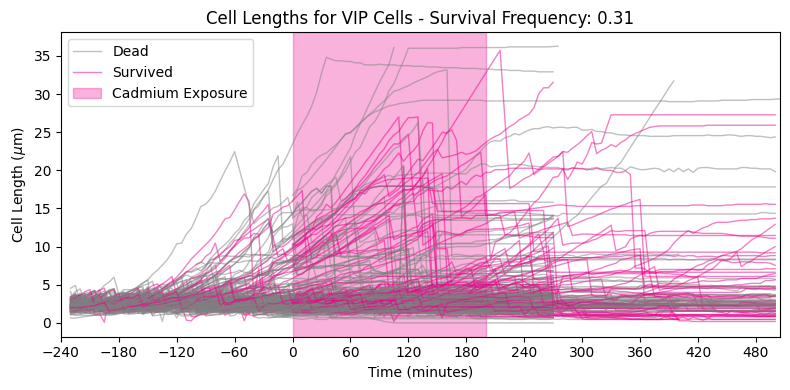

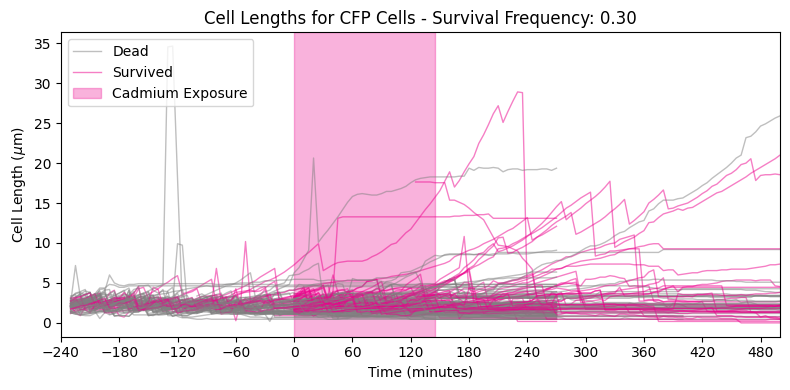

In [ ]:
def plot_all_cells_in_single_plot(all_data, df, cell_type_filter=None, frames2min=5, pixel2um=1 / 11):
    """Plots cell lengths of all cells in a single plot with survival status, showing only 'Survived' and 'Dead' in the legend."""
    identifiers = get_identifiers_by_cell_type(all_data, df, cell_type_filter)

    # Initialize figure for plotting
    plt.figure(figsize=(8, 4))

    # Set global min and max frames for x-limits
    global_min_frame = float('inf')
    global_max_frame = float('-inf')

    # Initialize variables to track if we've added the Survived/Dead lines to the legend
    survived_plotted = False
    dead_plotted = False
    survived_count = 0
    total_cells = 0

    for identifier in identifiers:
        # Extract the correct position and trap from the identifier
        position, trap = extract_position_and_trap(identifier)

        if position is None or trap is None:
            print(f"Warning: Could not extract position or trap from identifier {identifier}, skipping...")
            continue

        # Filter based on cell type if specified
        if cell_type_filter is not None:
            cell_type = get_cell_type(df, position, trap)
            if cell_type_filter != cell_type:
                continue

        # Filter the DataFrame for the correct position and trap
        filtered_df = df[(df['Position'] == position) & (df['Trap'] == trap)]
        if filtered_df.empty:
            print(f"Warning: No data found for position {position} and trap {trap}, skipping...")
            continue

        # Retrieve tend_cd for this specific identifier
        tend_cd = filtered_df['tend_cd'].values[0]

        # Analyze division events for this identifier
        time_series_data = get_time_series_of_cell_lengths(all_data, df, identifier)
        if time_series_data[0]:  # Only analyze if there is data
            frames, cell_lengths, cell_divisions, survived = analyze_division_events(time_series_data, tend_cd)

            total_cells += 1
            if survived:
                survived_count += 1

            # Set the survival status and line color based on survival
            line_color = '#EC008C' if survived else 'grey'
            label = None

            # Only add labels for "Survived" and "Dead" once
            if survived and not survived_plotted:
                label = "Survived"
                survived_plotted = True
            elif not survived and not dead_plotted:
                label = "Dead"
                dead_plotted = True

            # Shift frames by tini_cd and scale x and y data
            tini_cd = filtered_df['tini_cd'].values[0]
            scaled_x = (np.array(frames) - tini_cd) * frames2min
            scaled_y = np.array(cell_lengths) * pixel2um

            global_min_frame = min(global_min_frame, min(scaled_x))
            global_max_frame = max(global_max_frame, max(scaled_x))

            # Plot the time series for this cell
            plt.plot(scaled_x, scaled_y, color=line_color, linewidth=1, alpha=0.5, label=label)

    # Calculate survival frequency
    if total_cells > 0:
        survival_freq = survived_count / total_cells
    else:
        survival_freq = 0.0

    # Use the global x-limits for consistency
    plt.xlim([global_min_frame, global_max_frame])
    xticks = np.arange(-240, 540 , 60)
    plt.xticks(xticks)

    # Annotate the red box for cadmium exposure on the overall plot
    plt.axvspan(0, (tend_cd - tini_cd) * frames2min, color='#EC008C', alpha=0.3, label='Cadmium Exposure')

    # Add labels and legend
    plt.xlabel('Time (minutes)')
    plt.ylabel(r'Cell Length ($\mu$m)')
    plt.title(f'Cell Lengths for {cell_type_filter} Cells - Survival Frequency: {survival_freq:.2f}')



    # Only show "Survived" and "Dead" in the legend
    plt.legend(loc='upper left')

    # Display the plot
    plt.tight_layout()
    plt.show()

# Plot all VIP cells in a single plot
plot_all_cells_in_single_plot(all_data, df, cell_type_filter="VIP")

# Plot all CFP cells in a single plot
plot_all_cells_in_single_plot(all_data, df, cell_type_filter="CFP")


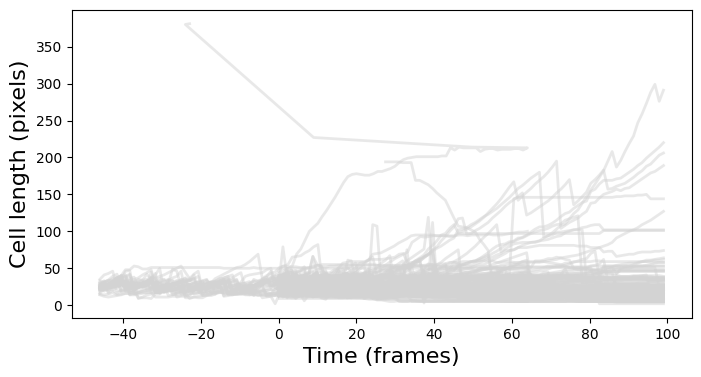

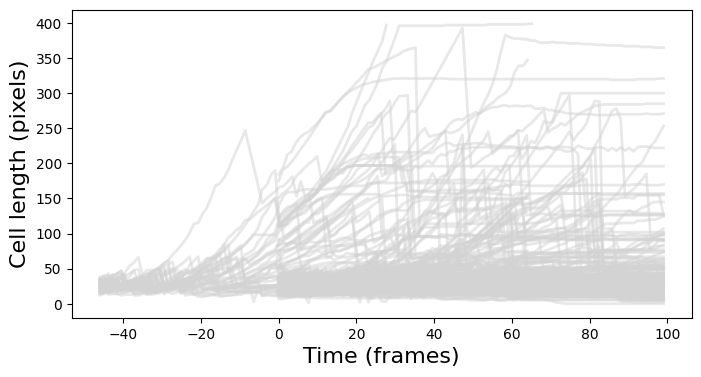

In [ ]:


def plot_trap_lengths(all_data, df, cell_type_filter=None, files_to_plot=None):
    colors = {1: 'blue', 2: '#EC008C'}
    cmap = plt.get_cmap("viridis")  # Use the viridis colormap
    x2frame = 10  # Define the constant for conversion

    plt.figure(figsize=(8, 4))

    # First plot all in light grey with transparency
    for file, data in all_data.items():
        trap_lengths = {}
        identifier = extract_file_identifier(file)  # Get the full identifier (e.g., 'EXP2_xy20_trap1')

        # Extract both position and trap
        position, trap = extract_position_and_trap(identifier)

        if position is None or trap is None:
            print(f"Warning: Could not extract position or trap from identifier {identifier}, skipping...")
            continue

        # Filter based on cell type if specified
        if cell_type_filter is not None:
            cell_type = get_cell_type(df, position, trap)
            if cell_type_filter != cell_type:
                continue

        # Check if the extracted position exists in the df['Position'] column
        filtered_df = df[df['Position'] == position]
        if filtered_df.empty:
            print(f"Warning: No tini_cd found for position {position}, skipping...")
            continue  # Skip this position if no matching rows are found

        # Retrieve the tini_cd and tend for this position from the DataFrame
        t_ini = filtered_df['tini_cd'].values[0]
        t_end = filtered_df['tend'].values[0]

        for trap_data in data:
            trap_id = trap_data['id']

            # Only consider traps with id=1 and id=2
            if trap_id not in colors:
                continue

            x_breakpoints = trap_data['x_breakpoints']
            y_breakpoints = trap_data['y_breakpoints']

            # Convert frames and adjust by tini_cd
            frames = [(x / x2frame) - t_ini for x in x_breakpoints]  # Adjusting by t_ini

            # Ensure both x_breakpoints and y_breakpoints have the same length
            min_length = min(len(x_breakpoints), len(y_breakpoints))
            x_breakpoints = x_breakpoints[:min_length]
            y_breakpoints = y_breakpoints[:min_length]

            # Filter out frames and breakpoints after t_end
            valid_indices = [i for i, frame in enumerate(frames) if frame <= (t_end - t_ini)]
            frames = [frames[i] for i in valid_indices]
            y_breakpoints = [y_breakpoints[i] for i in valid_indices]

            # Only process if there is data to process
            if frames and y_breakpoints:
                if trap_id not in trap_lengths:
                    trap_lengths[trap_id] = []
                trap_lengths[trap_id].append(y_breakpoints)

        if 1 in trap_lengths and 2 in trap_lengths:
            lengths_1 = trap_lengths[1][0]
            lengths_2 = trap_lengths[2][0]
            length_differences = [abs(l1 - l2) for l1, l2 in zip(lengths_1, lengths_2)]

            # Adjust transparency and width of the grey background lines
            plt.plot(frames[:len(length_differences)], length_differences, color='lightgrey', alpha=0.5, linewidth=2)

    # Then plot the selected files in color
    if files_to_plot is not None:
        num_files_to_plot = len(files_to_plot)
        color_map = cmap(np.linspace(0, 1, num_files_to_plot))

        for idx, (pkl_file, tif_file) in enumerate(files_to_plot):
            data = all_data[pkl_file]
            trap_lengths = {}
            identifier = extract_file_identifier(pkl_file)

            # Extract both position and trap
            position, trap = extract_position_and_trap(identifier)

            if position is None or trap is None:
                print(f"Warning: Could not extract position or trap from identifier {identifier}, skipping...")
                continue

            # Filter based on cell type if specified
            if cell_type_filter is not None:
                cell_type = get_cell_type(df, position, trap)
                if cell_type_filter != cell_type:
                    continue

            # Check if the extracted position exists in the df['Position'] column
            filtered_df = df[df['Position'] == position]
            if filtered_df.empty:
                print(f"Warning: No tini_cd found for position {position}, skipping...")
                continue  # Skip this position if no matching rows are found

            # Retrieve the tini_cd and tend for this position from the DataFrame
            t_ini = filtered_df['tini_cd'].values[0]
            t_end = filtered_df['tend'].values[0]

            for trap_data in data:
                trap_id = trap_data['id']

                # Only consider traps with id=1 and id=2
                if trap_id not in {1, 2}:
                    continue

                x_breakpoints = trap_data['x_breakpoints']
                y_breakpoints = trap_data['y_breakpoints']

                # Convert frames and adjust by tini_cd
                frames = [(x / x2frame) - t_ini for x in x_breakpoints]  # Adjusting by t_ini

                # Ensure both x_breakpoints and y_breakpoints have the same length
                min_length = min(len(x_breakpoints), len(y_breakpoints))
                x_breakpoints = x_breakpoints[:min_length]
                y_breakpoints = y_breakpoints[:min_length]

                # Filter out frames and breakpoints after t_end
                valid_indices = [i for i, frame in enumerate(frames) if frame <= (t_end - t_ini)]
                frames = [frames[i] for i in valid_indices]
                y_breakpoints = [y_breakpoints[i] for i in valid_indices]

                # Only process if there is data to process
                if frames and y_breakpoints:
                    if trap_id not in trap_lengths:
                        trap_lengths[trap_id] = []
                    trap_lengths[trap_id].append(y_breakpoints)

            if 1 in trap_lengths and 2 in trap_lengths:
                lengths_1 = trap_lengths[1][0]
                lengths_2 = trap_lengths[2][0]
                length_differences = [abs(l1 - l2) for l1, l2 in zip(lengths_1, lengths_2)]
                this_color = color_map[idx]

                # Increase linewidth and alpha for colored plots
                plt.plot(frames[:len(length_differences)], length_differences, label=extract_file_identifier(pkl_file), color=this_color, linewidth=3, alpha=0.8)

                # Analyze division events and plot them
                time_series_data = (frames[:len(length_differences)], length_differences)
                division_events = analyze_division_events(time_series_data)
                for i in range(len(frames)):
                    if division_events[2][i]:
                        plt.plot(frames[i], length_differences[i], 'o', color=this_color)

    plt.xlabel('Time (frames)', fontsize=16)
    plt.ylabel('Cell length (pixels)', fontsize=16)
    plt.show()

plot_trap_lengths(all_data, df, cell_type_filter='CFP')
plot_trap_lengths(all_data, df, cell_type_filter='VIP')


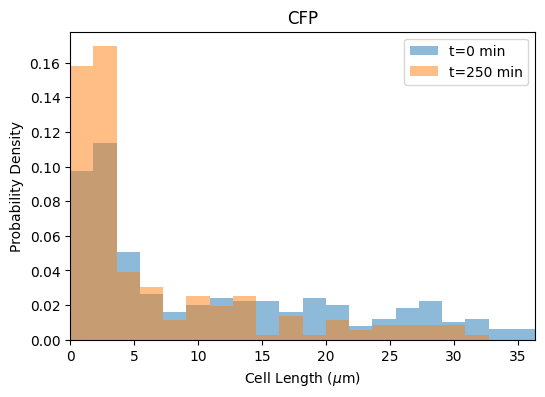

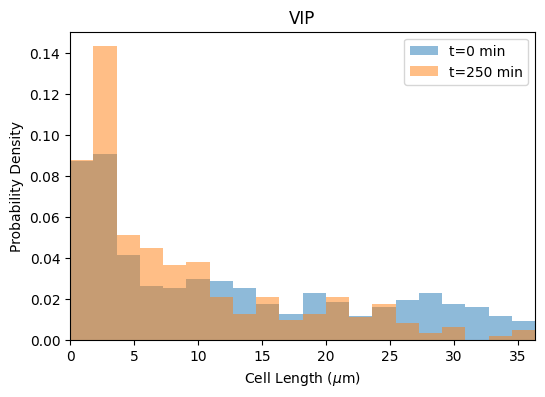

In [ ]:
def plot_cell_length_distribution(all_data, df, time_frames, cell_type_filter=None, files_to_plot=None, max_cell_length=400, pixel2um=1 / 11, frames2min=5, num_bins=20):
    if files_to_plot is not None:
        filtered_data = {pkl_file: all_data[pkl_file] for pkl_file, _ in files_to_plot if pkl_file in all_data}
    else:
        filtered_data = all_data

    all_cell_lengths = {time_frame: [] for time_frame in time_frames}

    # Collect cell lengths
    for time_frame in time_frames:
        for file, data in filtered_data.items():
            identifier = extract_file_identifier(file)  # e.g., 'EXP3_xy10_trap6'
            position, trap = extract_position_and_trap(identifier)  # Extract 'xy10' and 'trap6'

            if position is None or trap is None:
                print(f"Warning: Could not extract position or trap from identifier {identifier}, skipping...")
                continue

            # Filter based on cell type if specified
            if cell_type_filter is not None:
                cell_type = get_cell_type(df, position, trap)  # Pass both position and trap to get_cell_type
                if cell_type_filter != cell_type:
                    continue

            for trap_data in data:
                trap_id = trap_data['id']

                # Only consider traps with id=1 and id=2
                if trap_id not in {1, 2}:
                    continue

                y_breakpoints = trap_data['y_breakpoints']

                # Only process if there is data to process
                if y_breakpoints:
                    # Ensure the time_frame is within the bounds of y_breakpoints
                    if time_frame < len(y_breakpoints):
                        cell_length = y_breakpoints[time_frame]
                        cell_length_um = cell_length * pixel2um  # Convert to micrometers
                        if 0 < cell_length_um <= max_cell_length:  # Filter out zero and overly large lengths
                            all_cell_lengths[time_frame].append(cell_length_um)

    # Adjust the bin scaling dynamically
    bin_edges = np.linspace(0, max_cell_length * pixel2um, num_bins + 1)

    plt.figure(figsize=(6, 4))

    for time_frame, lengths in all_cell_lengths.items():
        if lengths:
            # Convert time_frame to minutes for the label
            time_in_minutes = time_frame * frames2min
            plt.hist(lengths, bins=bin_edges, alpha=0.5, density=True, label=f't={time_in_minutes} min')

    plt.xlabel(r'Cell Length ($\mu$m)')
    plt.ylabel('Probability Density')
    plt.xlim([0, max_cell_length * pixel2um])  # Adjusted to match scaled values

    # Adjust title based on the cell type filter
    plot_title = cell_type_filter if cell_type_filter else 'All Cell Types'
    plt.title(plot_title)

    plt.legend()
    plt.show()

files_to_plot = matched_files  # Use the matched files dataset
time_frames = [0, 50]  # Specify the time frames to plot
plot_cell_length_distribution(all_data, df, time_frames, cell_type_filter='CFP', files_to_plot=files_to_plot, num_bins=20)
plot_cell_length_distribution(all_data, df, time_frames, cell_type_filter='VIP', files_to_plot=files_to_plot, num_bins=20)


In [ ]:
def plot_heatmap_with_divisions(division_events, identifiers, filter_type='', critical_timepoint=50, frames2min=5, pixel2um=0.11):
    survived_events = []
    non_survived_events = []

    # Filter out cells that never divided
    division_events = [event for event in division_events if sum(event[2]) > 0]

    # Split the division events into survived and non-survived groups
    for event in division_events:
        frames, cell_lengths, cell_divisions, survived = event
        # Check if the cell divided after the critical time point
        divided_after_critical = any(frame >= critical_timepoint and div for frame, div in zip(frames, cell_divisions))
        if divided_after_critical:
            survived_events.append(event)
        else:
            non_survived_events.append(event)

    # Sort both groups by total number of divisions in decreasing order
    def sort_by_division_count(events):
        division_counts = [(sum(cell_divisions), i) for i, (_, _, cell_divisions, _) in enumerate(events)]
        sorted_indices = sorted(division_counts, key=lambda x: -x[0])  # Sort by division count (decreasing)
        return [events[i] for _, i in sorted_indices]

    survived_events = sort_by_division_count(survived_events)
    non_survived_events = sort_by_division_count(non_survived_events)

    # Combine survived and non-survived events
    sorted_division_events = survived_events + non_survived_events
    num_cells = len(sorted_division_events)

    # Find the maximum number of frames to ensure consistent heatmap dimensions
    num_frames = max(len(frames) for frames, _, _, _ in sorted_division_events)

    heatmap_data = np.zeros((num_cells, num_frames))

    total_lengths = []
    total_divisions = []
    division_rates = []
    elongation_rates = []  # Store elongation rates
    time_between_divisions_all = []  # Store mean time between division events for each cell

    for i, (frames, cell_lengths, cell_divisions, survived) in enumerate(sorted_division_events):
        # Populate the heatmap with cell lengths, converting from pixels to micrometers
        for j, frame in enumerate(frames):
            if j < len(cell_lengths):
                heatmap_data[i, j] = min(cell_lengths[j] * pixel2um, 100 * pixel2um)  # Cap cell lengths in \(\mu\)m

        # Collect data for statistics
        lengths_before_critical = [cell_lengths[j] * pixel2um for j, frame in enumerate(frames) if frame < critical_timepoint]
        divisions_before_critical = [cell_divisions[j] for j, frame in enumerate(frames) if frame < critical_timepoint]
        time_elapsed = max([frame for frame in frames if frame < critical_timepoint], default=0)

        total_lengths.extend(lengths_before_critical)
        total_divisions.extend(divisions_before_critical)

        if time_elapsed > 0:  # Avoid division by zero
            division_rate = sum(divisions_before_critical) / (time_elapsed * frames2min)
            division_rates.append(division_rate)

        # Compute elongation rate
        if len(frames) > 1:  # Ensure at least two time points
            time_intervals = np.diff(frames) * frames2min  # Convert frame differences to minutes
            length_intervals = np.diff([l * pixel2um for l in cell_lengths])  # Convert length differences to \(\mu\)m
            rates = length_intervals / time_intervals  # Compute elongation rates
            elongation_rates.extend(rates)

        # Compute mean time between division events for this cell
        division_frames = [frame for frame, div in zip(frames, cell_divisions) if div]
        if len(division_frames) > 1:  # At least two division events are needed
            time_intervals = np.diff(division_frames) * frames2min  # Convert to minutes
            mean_time_between_divisions = np.mean(time_intervals)
            time_between_divisions_all.append(mean_time_between_divisions)

    # Compute overall statistics
    mean_length = np.mean(total_lengths) if total_lengths else np.nan
    std_length = np.std(total_lengths) if total_lengths else np.nan

    mean_divisions = np.mean(total_divisions) if total_divisions else np.nan
    std_divisions = np.std(total_divisions) if total_divisions else np.nan

    mean_division_rate = np.mean(division_rates) if division_rates else np.nan
    std_division_rate = np.std(division_rates) if division_rates else np.nan

    mean_elongation_rate = np.mean(elongation_rates) if elongation_rates else np.nan
    std_elongation_rate = np.std(elongation_rates) if elongation_rates else np.nan

    mean_time_between_divisions_all = np.mean(time_between_divisions_all) if time_between_divisions_all else np.nan
    std_time_between_divisions_all = np.std(time_between_divisions_all) if time_between_divisions_all else np.nan

    # Statistics on survival
    num_survived = len(survived_events)
    num_non_survived = len(non_survived_events)
    survival_percentage = (num_survived / num_cells * 100) if num_cells > 0 else 0.0

    # Convert critical timepoint to minutes
    critical_timepoint_minutes = critical_timepoint * frames2min

    # Store statistics in a dictionary
    statistics = {
        "filter_type": filter_type or "All Cells",
        "critical_timepoint_frames": critical_timepoint,
        "critical_timepoint_minutes": critical_timepoint_minutes,
        "num_cells": num_cells,
        "num_survived": num_survived,
        "num_non_survived": num_non_survived,
        "survival_percentage": survival_percentage,
        "mean_cell_length": (mean_length, std_length, "μm"),
        "mean_divisions": (mean_divisions, std_divisions, "count"),
        "mean_division_rate": (mean_division_rate, std_division_rate, "divisions/min"),
        "mean_elongation_rate": (mean_elongation_rate, std_elongation_rate, "μm/min"),
        "mean_time_between_divisions": (mean_time_between_divisions_all, std_time_between_divisions_all, "minutes"),
    }

    # Print statistics
    print(f"Statistics for {filter_type or 'All Cells'}:")
    for key, value in statistics.items():
        if isinstance(value, tuple):
            print(f"  {key}: {value[0]:.4f} ± {value[1]:.4f} {value[2]}")
        elif isinstance(value, (float, int)):
            print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")
        else:
            print(f"  {key}: {value}")

    # Plot the heatmap, with the color representing cell length in micrometers
    plt.figure(figsize=(8, 4))
    heatmap = sns.heatmap(
        heatmap_data,
        cmap='viridis',
        vmax=100 * pixel2um,
        cbar_kws={'label': r'Cell Length ($\mu$m)'},  # Colorbar label
        yticklabels=False,
        xticklabels=False
    )

    # Adjust the colorbar label font size
    heatmap.figure.axes[-1].yaxis.label.set_size(10)

    # Mark divisions with a black overlay dot on top of the heatmap
    for i, (frames, cell_lengths, cell_divisions, survived) in enumerate(sorted_division_events):
        for j, frame in enumerate(frames):
            if j < len(cell_divisions) and cell_divisions[j]:
                plt.scatter(j + 0.5, i + 0.5, color='black', s=6)  # Mark division events

    # Add horizontal white line where the status changes from "survived" to "non-survived"
    if len(survived_events) > 0 and len(non_survived_events) > 0:
        plt.axhline(len(survived_events), color='white', linewidth=2)  # Horizontal line where status changes

    # Add vertical white dotted line at the critical time point
    #if critical_timepoint > 0:
    #    plt.axvline(critical_timepoint, color='white', linestyle='--', linewidth=2)  # Vertical dotted line at the critical timepoint

    # Convert frames to minutes and update xticks
    xticks = np.arange(0, num_frames, step=60 // frames2min)  # Tick every 60 minutes
    xtick_labels = [int(tick * frames2min) for tick in xticks]
    plt.xticks(xticks, labels=xtick_labels, fontsize=10)  # Adjust xticks fontsize

    # Add labels and title
    plt.xlabel('Time (minutes)', fontsize=11)
    plt.title(filter_type or 'All Cells', fontsize=11)

    plt.tight_layout()
    plt.show()

    return statistics


Statistics for VIP:
  filter_type: VIP
  critical_timepoint_frames: 36
  critical_timepoint_minutes: 180
  num_cells: 232
  num_survived: 145
  num_non_survived: 87
  survival_percentage: 62.5000
  mean_cell_length: 4.1910 ± 4.1259 μm
  mean_divisions: 0.0696 ± 0.2544 count
  mean_division_rate: 0.0143 ± 0.0055 divisions/min
  mean_elongation_rate: 0.0050 ± 0.1708 μm/min
  mean_time_between_divisions: 72.4778 ± 33.0375 minutes


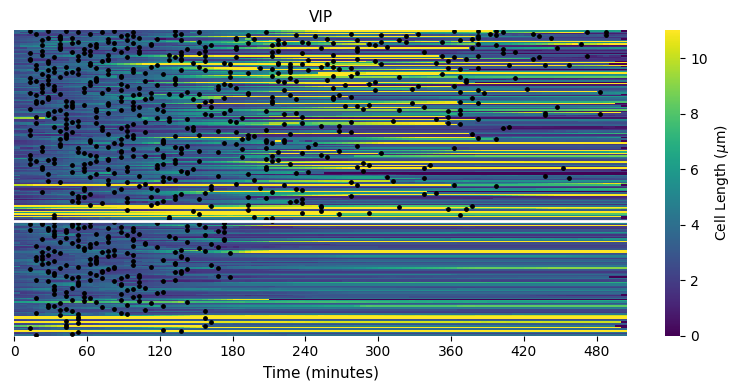

In [ ]:
# Collect division events for the given cell type
cell_type_filter = "VIP"  # Specify the cell type you want to filter by
identifiers = get_identifiers_by_cell_type(all_data, df, cell_type_filter)
division_events = []
time_between_divisions = []  # List to store mean time between division events for each cell

for identifier in identifiers:
    time_series_data = get_time_series_of_cell_lengths(all_data, df, identifier)

    # Extract the position and trap from the identifier
    position, trap = extract_position_and_trap(identifier)

    # Get the tend_cd value for this identifier
    filtered_df = df[(df['Position'] == position) & (df['Trap'] == trap)]
    if not filtered_df.empty:
        tend_cd = filtered_df['tend_cd'].values[0]  # Get the tend_cd value

        if time_series_data[0]:  # Only analyze if there is data
            # Pass both time_series_data and tend_cd to analyze_division_events
            frames, cell_lengths, cell_divisions, survived = analyze_division_events(time_series_data, tend_cd)
            division_events.append((frames, cell_lengths, cell_divisions, survived))

            # Calculate time intervals between division events
            division_frames = [frame for frame, div in zip(frames, cell_divisions) if div]
            if len(division_frames) > 1:  # At least two division events are needed to compute intervals
                intervals = np.diff(division_frames)  # Time differences between consecutive division events
                mean_interval = np.mean(intervals)  # Average time between division events
                time_between_divisions.append(mean_interval)

    else:
        print(f"Warning: No tend_cd found for identifier {identifier}, skipping...")


# Plot the heatmap with division events
stats_VIP=plot_heatmap_with_divisions(division_events, identifiers, cell_type_filter, 36)


Statistics for CFP:
  filter_type: CFP
  critical_timepoint_frames: 36
  critical_timepoint_minutes: 180
  num_cells: 128
  num_survived: 77
  num_non_survived: 51
  survival_percentage: 60.1562
  mean_cell_length: 2.9996 ± 1.6315 μm
  mean_divisions: 0.0779 ± 0.2681 count
  mean_division_rate: 0.0159 ± 0.0072 divisions/min
  mean_elongation_rate: 0.0018 ± 0.1441 μm/min
  mean_time_between_divisions: 68.3713 ± 31.5500 minutes


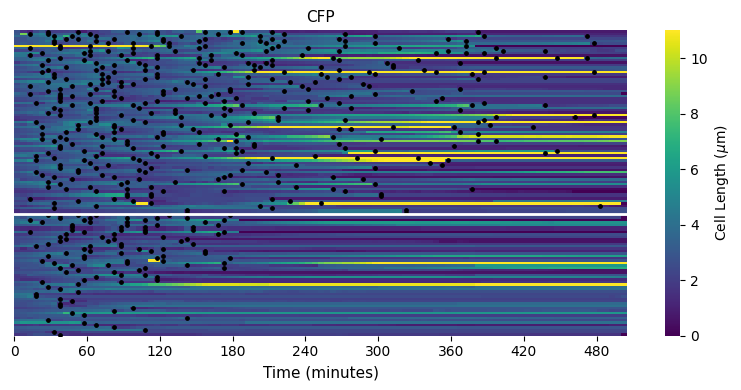

In [ ]:
# Updated loop for collecting division events for the given cell type
cell_type_filter = "CFP"  # Specify the cell type you want to filter by
identifiers = get_identifiers_by_cell_type(all_data, df, cell_type_filter)
division_events = []

for identifier in identifiers[1:]:
    # Get the time series data for the specific cell
    time_series_data = get_time_series_of_cell_lengths(all_data, df, identifier)

    # Retrieve the tend_cd value from the DataFrame
    position, trap = extract_position_and_trap(identifier)
    filtered_df = df[(df['Position'] == position) & (df['Trap'] == trap)]

    if filtered_df.empty:
        print(f"Warning: No data found for position {position} and trap {trap}, skipping...")
        continue

    tend_cd = filtered_df['tend_cd'].values[0]

    if time_series_data[0]:  # Only analyze if there is data
        division_events.append(analyze_division_events(time_series_data, tend_cd))

# Plot the heatmap with division events
stats_CFP=plot_heatmap_with_divisions(division_events, identifiers, cell_type_filter, 36)


In [ ]:
print("VIP Stats:", stats_VIP)
print("CFP Stats:", stats_CFP)


def store_stats(stats_VIP, stats_CFP, data_path, expeID):
    """
    Stores the VIP and CFP statistics in a pickle file.

    Parameters:
    - stats_VIP: Dictionary of statistics for VIP cells.
    - stats_CFP: Dictionary of statistics for CFP cells.
    - data_path: Base directory where the file should be stored.
    - expeID: Experiment ID used to name the file.

    The output file will be stored as: data_path + expeID + '.pkl'
    """
    # Combine the statistics into a single dictionary
    combined_stats = {
        'stats_VIP': stats_VIP,
        'stats_CFP': stats_CFP
    }

    # Construct the full filename
    filename = os.path.join(data_path, expeID + '.pkl')

    # Save the dictionary to the pickle file
    with open(filename, 'wb') as f:
        pickle.dump(combined_stats, f)

    print(f"Stored statistics in {filename}")

store_stats(stats_VIP, stats_CFP, data_path, expeID)



VIP Stats: {'filter_type': 'VIP', 'critical_timepoint_frames': 36, 'critical_timepoint_minutes': 180, 'num_cells': 232, 'num_survived': 145, 'num_non_survived': 87, 'survival_percentage': 62.5, 'mean_cell_length': (np.float64(4.191041039836322), np.float64(4.125884783792212), 'μm'), 'mean_divisions': (np.float64(0.06956312432302322), np.float64(0.25440930811871415), 'count'), 'mean_division_rate': (np.float64(0.014298082869511446), np.float64(0.005470998063173711), 'divisions/min'), 'mean_elongation_rate': (np.float64(0.005035383209296253), np.float64(0.17077055132558933), 'μm/min'), 'mean_time_between_divisions': (np.float64(72.47779623477298), np.float64(33.037491757160105), 'minutes')}
CFP Stats: {'filter_type': 'CFP', 'critical_timepoint_frames': 36, 'critical_timepoint_minutes': 180, 'num_cells': 128, 'num_survived': 77, 'num_non_survived': 51, 'survival_percentage': 60.15625, 'mean_cell_length': (np.float64(2.9995590482427414), np.float64(1.6314521268462352), 'μm'), 'mean_divisio

VIP (time=40)
Survived Lengths Range: Min=1.32, Max=39.60
Non-Survived Lengths Range: Min=0.66, Max=35.20
Mann-Whitney U Test:
Statistic: 10097.0
p-value: 4.114298883269202e-06
Survived Median: 4.73 μm
Non-Survived Median: 2.97 μm


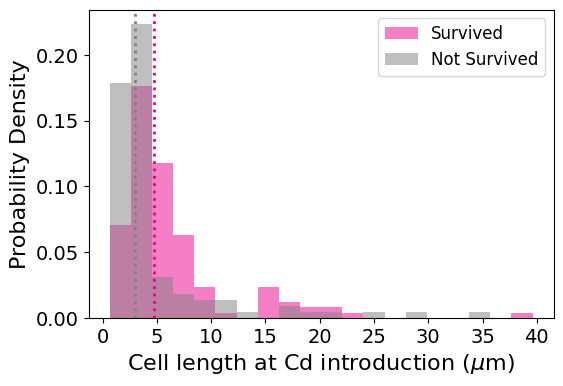

CFP (time=40)
Survived Lengths Range: Min=1.32, Max=14.30
Non-Survived Lengths Range: Min=0.55, Max=10.23
Mann-Whitney U Test:
Statistic: 2811.0
p-value: 0.019979673441631568
Survived Median: 3.03 μm
Non-Survived Median: 2.31 μm


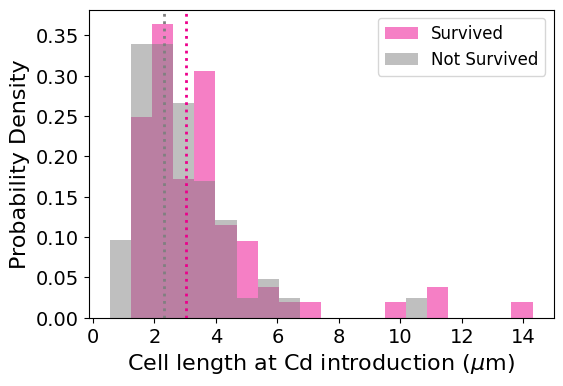

In [ ]:


# Conversion factor
pixel2um = 0.11  # Conversion from pixels to micrometers

def plot_survival_vs_non_survival_distributions(all_data, df, critical_timepoint, cell_type_filter=None):
    identifiers = get_identifiers_by_cell_type(all_data, df, cell_type_filter)
    survived_lengths = []
    non_survived_lengths = []

    for identifier in identifiers:
        time_series_data = get_time_series_of_cell_lengths(all_data, df, identifier)
        if time_series_data[0]:  # Only analyze if there is data

            # Retrieve tend_cd for this specific identifier
            position, trap = extract_position_and_trap(identifier)
            filtered_df = df[(df['Position'] == position) & (df['Trap'] == trap)]
            if not filtered_df.empty:
                tend_cd = filtered_df['tend_cd'].values[0]
            else:
                print(f"Warning: No tend_cd found for identifier {identifier}, skipping...")
                continue

            frames, cell_lengths, cell_divisions, _ = analyze_division_events(time_series_data, tend_cd)

            # Determine if the cell divided after the critical timepoint
            divided_after_critical = any(div for frame, div in zip(frames, cell_divisions) if frame > critical_timepoint)

            # Get the cell length at the critical timepoint
            if critical_timepoint in frames:
                index = np.where(frames == critical_timepoint)[0][0]
                length_at_critical = cell_lengths[index] * pixel2um  # Convert from pixels to micrometers
                if length_at_critical > 0:  # Filter out zero lengths
                    if divided_after_critical:
                        survived_lengths.append(length_at_critical)
                    else:
                        non_survived_lengths.append(length_at_critical)

    # Print data range for debugging
    print(f"Survived Lengths Range: Min={np.min(survived_lengths):.2f}, Max={np.max(survived_lengths):.2f}")
    print(f"Non-Survived Lengths Range: Min={np.min(non_survived_lengths):.2f}, Max={np.max(non_survived_lengths):.2f}")

    # Define dynamic bins based on data range
    all_lengths = survived_lengths + non_survived_lengths
    if all_lengths:
        min_length = np.min(all_lengths)
        max_length = np.max(all_lengths)
        num_bins = 20  # Define the desired number of bins
        bin_edges = np.linspace(min_length, max_length, num_bins + 1)
    else:
        print("No valid data to plot.")
        return

    # Perform the Mann-Whitney U test
    if survived_lengths and non_survived_lengths:
        stat, p_value = mannwhitneyu(survived_lengths, non_survived_lengths, alternative='two-sided')
        print(f'Mann-Whitney U Test:\nStatistic: {stat}\np-value: {p_value}')
    else:
        print('Not enough data for Mann-Whitney U Test.')

    # Plot the distributions
    plt.figure(figsize=(6, 4))

    if survived_lengths:
        plt.hist(survived_lengths, bins=bin_edges, alpha=0.5, density=True, label='Survived', color='#EC008C')
        survived_median = np.median(survived_lengths)
        plt.axvline(survived_median, color='#EC008C', linestyle='dotted', linewidth=2)
        print(f"Survived Median: {survived_median:.2f} μm")

    if non_survived_lengths:
        plt.hist(non_survived_lengths, bins=bin_edges, alpha=0.5, density=True, label='Not Survived', color='grey')
        non_survived_median = np.median(non_survived_lengths)
        plt.axvline(non_survived_median, color='grey', linestyle='dotted', linewidth=2)
        print(f"Non-Survived Median: {non_survived_median:.2f} μm")

    plt.xlabel(r'Cell length at Cd introduction ($\mu$m)', fontsize=16)
    plt.ylabel('Probability Density', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.show()

critical_timepoint = 40  # Define your critical timepoint
cell_type_filter = "VIP"  # Optionally specify the cell type
print(f"{cell_type_filter} (time={critical_timepoint})")
plot_survival_vs_non_survival_distributions(all_data, df, critical_timepoint, cell_type_filter)

cell_type_filter = "CFP"  # Optionally specify the cell type
print(f"{cell_type_filter} (time={critical_timepoint})")
plot_survival_vs_non_survival_distributions(all_data, df, critical_timepoint, cell_type_filter)


VIP - Mann-Whitney U Test:
Statistic: 7004.0
p-value: 0.0007196341680853315
VIP - Total cells: 294
VIP - Total cells analyzed after filtering: 224
VIP - Survived: 72
VIP - Not survived: 152
CFP - Mann-Whitney U Test:
Statistic: 2581.5
p-value: 4.472059157306677e-05
CFP - Total cells: 164
CFP - Total cells analyzed after filtering: 127
CFP - Survived: 42
CFP - Not survived: 85


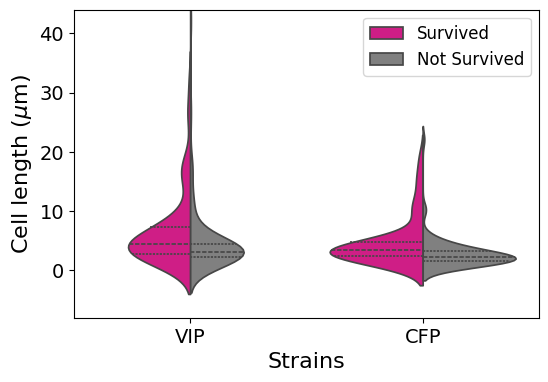

In [ ]:


def plot_survival_vs_non_survival_distributions(all_data, df, max_cell_length_pixels=400, pixel2um=0.11):
    cell_types = ["VIP", "CFP"]
    results = {}

    for cell_type_filter in cell_types:
        identifiers = get_identifiers_by_cell_type(all_data, df, cell_type_filter)
        survived_lengths = []
        non_survived_lengths = []

        for identifier in identifiers:
            time_series_data = get_time_series_of_cell_lengths(all_data, df, identifier)
            if time_series_data[0]:  # Only analyze if there is data

                # Retrieve tend_cd for this specific identifier
                position, trap = extract_position_and_trap(identifier)
                filtered_df = df[(df['Position'] == position) & (df['Trap'] == trap)]
                if not filtered_df.empty:
                    tend_cd = filtered_df['tend_cd'].values[0]
                else:
                    print(f"Warning: No tend_cd found for identifier {identifier}, skipping...")
                    continue

                frames, cell_lengths, cell_divisions, _ = analyze_division_events(time_series_data, tend_cd)

                # Skip cells that never divided
                if not any(div for frame, div in zip(frames, cell_divisions) if frame < tend_cd):
                    continue

                # Determine if the cell divided after or at the tend_cd
                divided_after_tend_cd = any(div for frame, div in zip(frames, cell_divisions) if frame >= tend_cd)

                # Get the cell length at the tend_cd
                if tend_cd in frames:
                    index = np.where(frames == tend_cd)[0][0]
                    length_at_tend_cd = cell_lengths[index] * pixel2um  # Convert pixels to micrometers
                    if length_at_tend_cd > 0:  # Filter out zero lengths
                        if divided_after_tend_cd:
                            survived_lengths.append(length_at_tend_cd)
                        else:
                            non_survived_lengths.append(length_at_tend_cd)

        # Perform the Mann-Whitney U test
        if survived_lengths and non_survived_lengths:
            stat, p_value = mannwhitneyu(survived_lengths, non_survived_lengths, alternative='two-sided')
            results[cell_type_filter] = (survived_lengths, non_survived_lengths, stat, p_value)
            print(f'{cell_type_filter} - Mann-Whitney U Test:\nStatistic: {stat}\np-value: {p_value}')
        else:
            stat, p_value = None, None
            results[cell_type_filter] = (survived_lengths, non_survived_lengths, stat, p_value)
            print(f'{cell_type_filter} - Not enough data for Mann-Whitney U Test.')

        # Debugging step: Print filtered cell counts
        print(f"{cell_type_filter} - Total cells: {len(identifiers)}")
        print(f"{cell_type_filter} - Total cells analyzed after filtering: {len(survived_lengths) + len(non_survived_lengths)}")
        print(f"{cell_type_filter} - Survived: {len(survived_lengths)}")
        print(f"{cell_type_filter} - Not survived: {len(non_survived_lengths)}")

    # Prepare data for plotting
    data = []
    labels = []
    hue = []

    for cell_type_filter in cell_types:
        survived_lengths, non_survived_lengths, stat, p_value = results[cell_type_filter]

        if survived_lengths:
            data.extend(survived_lengths)
            labels.extend([cell_type_filter] * len(survived_lengths))
            hue.extend(['Survived'] * len(survived_lengths))

        if non_survived_lengths:
            data.extend(non_survived_lengths)
            labels.extend([cell_type_filter] * len(non_survived_lengths))
            hue.extend(['Not Survived'] * len(non_survived_lengths))

    plt.figure(figsize=(6, 4))
    sns.violinplot(x=labels, y=data, hue=hue, split=True, inner="quartile", palette={"Survived": "#EC008C", "Not Survived": "grey"})

    plt.xlabel('Strains', fontsize=16)
    plt.ylabel(r'Cell length ($\mu$m)', fontsize=16)  # Update the label to µm
    plt.xticks(fontsize=14)
    plt.legend(fontsize=12)
    plt.yticks(fontsize=14)
    plt.ylim([-8, max_cell_length_pixels * pixel2um])  # Scale y-axis to match converted lengths
    plt.show()

plot_survival_vs_non_survival_distributions(all_data, df)


VIP - Total cells: 294
VIP - Cells analyzed after filtering: 228
VIP - Survived: 99
VIP - Not Survived: 129


<ipython-input-27-c289c24332fd>:65: RuntimeWarning: invalid value encountered in cast
  bins = np.round(bins).astype(int)  # Round to whole units for cleaner labels


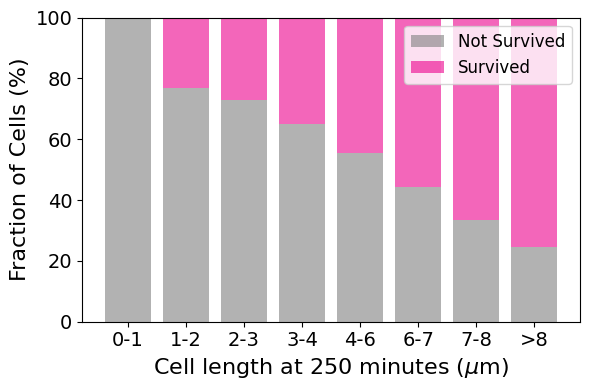

CFP - Total cells: 164
CFP - Cells analyzed after filtering: 127
CFP - Survived: 66
CFP - Not Survived: 61


<ipython-input-27-c289c24332fd>:65: RuntimeWarning: invalid value encountered in cast
  bins = np.round(bins).astype(int)  # Round to whole units for cleaner labels


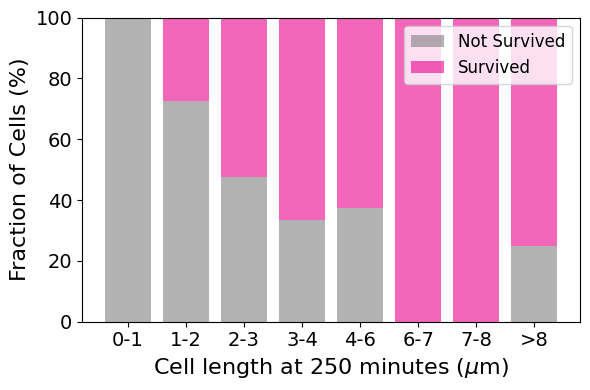

In [ ]:
def plot_binned_length_vs_survival_fraction(
    all_data,
    df,
    critical_timepoint=50,
    num_bins=5,
    max_length_for_bins_pixels=150,
    cell_type_filter=None,
    pixel2um=0.11,
    frames2min=5
):
    # Data containers for cell length and survival status
    cell_lengths_at_critical = []
    survival_status = []  # 1 = survived (divided), 0 = not survived (did not divide)

    # Get identifiers based on the cell type filter
    identifiers = get_identifiers_by_cell_type(all_data, df, cell_type_filter)

    # Iterate over all division events corresponding to the filtered identifiers
    for identifier in identifiers:
        time_series_data = get_time_series_of_cell_lengths(all_data, df, identifier)
        if time_series_data[0]:  # Only analyze if there is data

            # Retrieve the tend_cd for this specific identifier
            position, trap = extract_position_and_trap(identifier)
            filtered_df = df[(df['Position'] == position) & (df['Trap'] == trap)]
            if not filtered_df.empty:
                tend_cd = filtered_df['tend_cd'].values[0]
            else:
                print(f"Warning: No tend_cd found for identifier {identifier}, skipping...")
                continue

            frames, cell_lengths, cell_divisions, survived = analyze_division_events(time_series_data, tend_cd)

            # Skip cells that never divided before the critical timepoint
            if not any(div for frame, div in zip(frames, cell_divisions) if frame < critical_timepoint):
                continue

            # Find the cell length at the critical timepoint
            if critical_timepoint in frames:
                index_at_critical = np.where(frames == critical_timepoint)[0][0]
                length_at_critical = cell_lengths[index_at_critical] * pixel2um  # Convert pixels to micrometers

                # Check if the cell divided after the critical timepoint
                divided_after_critical = any(div for frame, div in zip(frames, cell_divisions) if frame >= critical_timepoint)
                status = 1 if divided_after_critical else 0

                # Append the data to the lists
                cell_lengths_at_critical.append(length_at_critical)
                survival_status.append(status)

    # Debugging step: Print filtered cell counts
    print(f"{cell_type_filter} - Total cells: {len(identifiers)}")
    print(f"{cell_type_filter} - Cells analyzed after filtering: {len(cell_lengths_at_critical)}")
    print(f"{cell_type_filter} - Survived: {np.sum(survival_status)}")
    print(f"{cell_type_filter} - Not Survived: {len(survival_status) - np.sum(survival_status)}")

    # Convert to numpy arrays for easier manipulation
    cell_lengths_at_critical = np.array(cell_lengths_at_critical)
    survival_status = np.array(survival_status)

    # Define the bins for cell lengths, rounded to whole units
    max_length_for_bins_um = max_length_for_bins_pixels * pixel2um  # Convert bin limit to micrometers
    bins = np.linspace(0, max_length_for_bins_um, num_bins)
    bins = np.append(bins, [np.inf])  # Add an infinite bin to capture lengths > max_length_for_bins
    bins = np.round(bins).astype(int)  # Round to whole units for cleaner labels
    bin_labels = [f'{bins[i]}-{bins[i+1]}' if i < len(bins) - 2 else f'>{bins[i]}' for i in range(len(bins) - 1)]

    # Initialize arrays to count survived and non-survived cells in each bin
    survived_in_bins = np.zeros(num_bins)
    total_in_bins = np.zeros(num_bins)

    # Bin the data based on cell lengths
    for i in range(num_bins):
        if i < num_bins - 1:
            in_bin = (cell_lengths_at_critical >= bins[i]) & (cell_lengths_at_critical < bins[i + 1])
        else:
            in_bin = cell_lengths_at_critical >= bins[i]  # All lengths >= max_length_for_bins
        total_in_bins[i] = np.sum(in_bin)
        survived_in_bins[i] = np.sum(survival_status[in_bin])

    # Calculate the fraction of survived and non-survived cells in each bin
    survived_fraction = 100 * survived_in_bins / total_in_bins
    survived_fraction[total_in_bins == 0] = 0  # Set fraction to 0 where no cells are in the bin

    non_survived_fraction = 100 * (total_in_bins - survived_in_bins) / total_in_bins
    non_survived_fraction[total_in_bins == 0] = 0

    # Create the stacked bar plot
    plt.figure(figsize=(6, 4))
    plt.bar(bin_labels, non_survived_fraction, label='Not Survived', color='grey', alpha=0.6)
    plt.bar(bin_labels, survived_fraction, bottom=non_survived_fraction, label='Survived', color='#EC008C', alpha=0.6)

    # Labeling
    plt.xlabel(r'Cell length at %s minutes ($\mu$m)'%(critical_timepoint*frames2min), fontsize=16)
    plt.ylabel('Fraction of Cells (%)', fontsize=16)
    plt.legend(loc='upper right', fontsize=12)
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14)

    # Set x-ticks without decimal points
    plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels)

    # Show the plot
    plt.tight_layout()
    plt.show()


plot_binned_length_vs_survival_fraction(all_data, df, critical_timepoint=50, num_bins=8, max_length_for_bins_pixels=70, cell_type_filter='VIP', pixel2um=pixel2um, frames2min=frames2min)
plot_binned_length_vs_survival_fraction(all_data, df, critical_timepoint=50, num_bins=8, max_length_for_bins_pixels=70, cell_type_filter='CFP', pixel2um=pixel2um, frames2min=frames2min)
